In [10]:
import numpy as np
import pandas as pd
import nbformat
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import re
import csv
from tqdm import tqdm


In [13]:
nb = nbformat.read("rank_swapping.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 277


## Read the Data

In [2]:
data = "train_data.csv"
df1 = pd.read_csv(data)

## Data Preprocessing

In [3]:
#Prepare card id and ip id for plotting

# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df1['card_id'])
df1['card_id'] = card_enc.transform(df1.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df1['ip_id'])
df1['ip_id'] = ip_enc.transform(df1.ip_id)


## Data Preprocessing

In [4]:
data = "train_data.csv"
df1 = pd.read_csv(data)

#Encoding, Cleaning the data
df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

#Feature Engineering
df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)

df1['accountcode'] = df1['accountcode'].apply(lambda x: re.sub('Account','',x))
df1['accountcode_cc'] = 0
df1.loc[(df1['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df1.loc[(df1['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df1.loc[(df1['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df1.loc[(df1['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

In [5]:
def rank_swapping(data_original, p, num_swaps, columns):
    data = data_original.copy()
    for i, column in enumerate(columns):
        # Sort the data by a column
        data = data.sort_values(data.columns[column])
        data = data.to_numpy()
        # Perform swaps on the selected column and within p rows of the randomly selected row
        for _ in tqdm(range(num_swaps)):
            # Get a random index to swap
            swap_index1 = np.random.randint(0, len(data))
            # Set a minimum and maximum index for the swapping
            max_index = min(len(data), swap_index1 + p)
            min_index = max(0, swap_index1 - p)

            # Get a random index to swap within the min and max index
            swap_index2 = np.random.randint(min_index, max_index)

            #Swap the rows
            temp = data[swap_index1][column]
            data[swap_index1][column] = data[swap_index2][column]
            data[swap_index2][column] = temp
        # Turn the np array back into a pd data frame
        data = pd.DataFrame(data, columns=data_original.columns)

    # Return the order of rows to its original
    data = data.sort_values(data.columns[0])
    return data

ranked_frame = rank_swapping(df1, 300, 5000000, [1, 4, 5, 6, 16])
original_values = df1.to_numpy()
print(np.equal(ranked_frame, original_values).all())
same_rows = 0
for i in range(len(ranked_frame)):
    if np.equal(ranked_frame.to_numpy()[i], original_values[i]).all():
        same_rows += 1
print('number of rows still the same: ', same_rows)
df1 = ranked_frame

100%|██████████| 5000000/5000000 [00:45<00:00, 108971.64it/s]


Id                               True
issuercountrycode               False
txvariantcode                    True
bin                              True
amount                          False
currencycode                    False
shoppercountrycode              False
shopperinteraction               True
cardverificationcodesupplied     True
cvcresponsecode                  True
accountcode                      True
mail_id                          True
ip_id                            True
card_id                          True
label                            True
countries_equal                  True
amount_eur                      False
accountcode_cc                   True
dtype: bool
number of rows still the same:  8932


In [6]:
unique_issuer_cc = df1['issuercountrycode'].unique()
unique_shopper_cc = df1['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
lb = LabelBinarizer()
y = lb.fit_transform(df1['issuercountrycode'])

# Create a new DataFrame with the transformed 'issuercountrycode' column
df2 = pd.DataFrame(y, columns=['issuercountrycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'issuercountrycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('issuercountrycode', axis=1), df2], axis=1)

y = lb.fit_transform(df1['shoppercountrycode'])

# Create a new DataFrame with the transformed 'issuercountrycode' column
df2 = pd.DataFrame(y, columns=['shoppercountrycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'issuercountrycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('shoppercountrycode', axis=1), df2], axis=1)

lb2 = LabelBinarizer()
y = lb2.fit_transform(df1['txvariantcode'])

# Create a new DataFrame with the transformed 'txvariantcode' column
df2 = pd.DataFrame(y, columns=['txvariantcode_'+str(i) for i in range(y.shape[1])])

# Replace the 'txvariantcode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('txvariantcode', axis=1), df2], axis=1)

lb3 = LabelBinarizer()
y = lb3.fit_transform(df1['currencycode'])

# Create a new DataFrame with the transformed 'currencycode' column
df2 = pd.DataFrame(y, columns=['currencycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'currencycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('currencycode', axis=1), df2], axis=1)

lb4 = LabelBinarizer()
y = lb4.fit_transform(df1['shopperinteraction'])

# Create a new DataFrame with the transformed 'shopperinteraction' column
df2 = pd.DataFrame(y, columns=['shopperinteraction_'+str(i) for i in range(y.shape[1])])

# Replace the 'shopperinteraction' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('shopperinteraction', axis=1), df2], axis=1)

lb5 = LabelBinarizer()
y = lb5.fit_transform(df1['accountcode_cc'])

# Create a new DataFrame with the transformed 'accountcode_cc' column
df2 = pd.DataFrame(y, columns=['accountcode_cc_'+str(i) for i in range(y.shape[1])])

# Replace the 'accountcode_cc' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('accountcode_cc', axis=1), df2], axis=1)

# drop id, mail_id, ip_id, card_id
df1 = df1.drop(['Id','mail_id','ip_id','card_id', 'amount', 'accountcode'], axis=1)

processed_df1 = df1

In [7]:
# Separate features and labels
X = df1.drop('label', axis=1)
y = df1['label']

y = y.astype('int')

# Define the number of folds
n_splits = 10

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store the predictions, probability and truth
y_proba_all_dec_tree = []
y_predicts_all_dec_tree = []
y_truth_all_dec_tree = []

y_proba_all_mlp = []
y_predicts_all_mlp = []
y_truth_all_mlp = []

y_proba_all_log = []
y_predicts_all_log = []
y_truth_all_log = []

round_counter = 0
# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    round_counter += 1
    print('round ', round_counter, ' of ', n_splits)
    # Split the data into training and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create and train the Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_dec_tree.extend(y_proba)
    y_predicts_all_dec_tree.extend(y_pred)
    y_truth_all_dec_tree.extend(y_test)

    # use a neural network for classification
    # Create and train the Multi-Layer Perceptron Classifier
    clf = MLPClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_mlp.extend(y_proba)
    y_predicts_all_mlp.extend(y_pred)
    y_truth_all_mlp.extend(y_test)

    # Create a logistic regression object
    clf = LogisticRegression()

    # Fit the model using the training data
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_log.extend(y_proba)
    y_predicts_all_log.extend(y_pred)
    y_truth_all_log.extend(y_test)

round  1  of  10
round  2  of  10
round  3  of  10
round  4  of  10
round  5  of  10
round  6  of  10
round  7  of  10
round  8  of  10
round  9  of  10
round  10  of  10


In [8]:
# Calculate confusion_mat score
confusion_mat_dec_tree = confusion_matrix(y_truth_all_dec_tree, y_predicts_all_dec_tree)

# Print the confusion_mat score
print("confusion_mat score decision tree:")
print(confusion_mat_dec_tree)

# Calculate confusion_mat score
confusion_mat_mlp = confusion_matrix(y_truth_all_mlp, y_predicts_all_mlp)

# Print the confusion_mat score
print("confusion_mat score mlp:")
print(confusion_mat_mlp)

# Calculate confusion_mat score
confusion_mat_log = confusion_matrix(y_truth_all_log, y_predicts_all_log)

# Print the confusion_mat score
print("confusion_mat score logistic regression:")
print(confusion_mat_log)

confusion_mat score decision tree:
[[189084    268]
 [   262     14]]
confusion_mat score mlp:
[[189352      0]
 [   276      0]]
confusion_mat score logistic regression:
[[189349      3]
 [   276      0]]


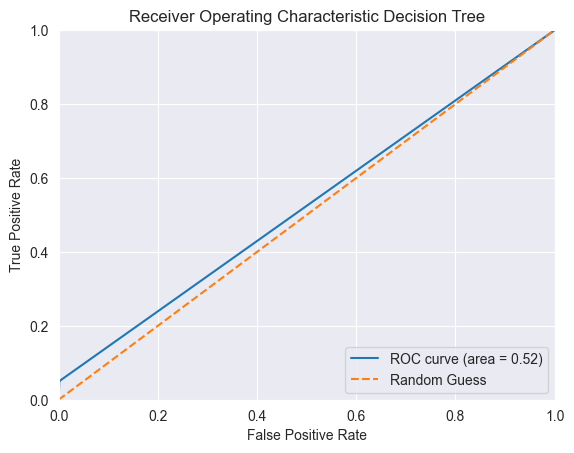

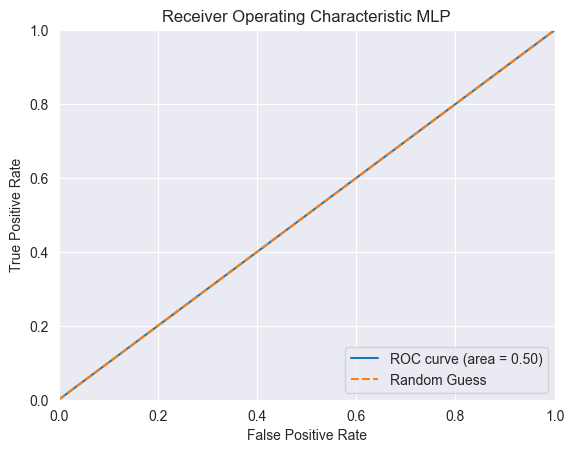

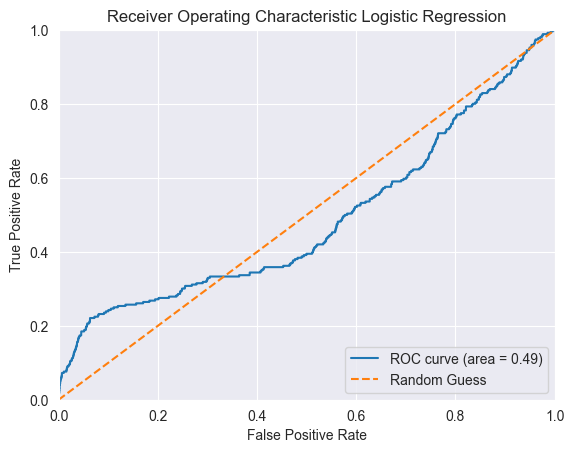

In [9]:
# Get the probability of being a fraud transaction for every sample
one_prob_dec_tree = [lst[1] for lst in y_proba_all_dec_tree]
fpr, tpr, thresholds = roc_curve(y_truth_all_dec_tree, one_prob_dec_tree)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Decision Tree')
plt.legend(loc="lower right")
plt.show()

# Get the probability of being a fraud transaction for every sample
one_prob_mlp = [lst[1] for lst in y_proba_all_mlp]
fpr, tpr, thresholds = roc_curve(y_truth_all_mlp, one_prob_mlp)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic MLP')
plt.legend(loc="lower right")
plt.show()

# Get the probability of being a fraud transaction for every sample
one_prob_log = [lst[1] for lst in y_proba_all_log]
fpr, tpr, thresholds = roc_curve(y_truth_all_log, one_prob_log)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Logistic Regression')
plt.legend(loc="lower right")
plt.show()

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

The ROC curves do not tell us much for the decision three and MLP. This is because a decision three does not give probabilities other than 0 and 1. Basically there are 3 different thresholds for classifying: t<0 (all cases are fraud cases), 0<t<1 cases are fraud or not based on the decision tree and t>1 no fraud cases at all. Because the data is so imbalanced, the MLP has learned to classify all cases as normal transactions. This gives two points on the ROC curve: either all are fraud or all are normal. This gives the same line as a random guess.

The logistic regression does give probabilities and therefor has a useful ROC curve. It will perform best at around a true positive rate of 0.25.

The classifiers perform almost exactly the same on the data before and after rank swapping. In terms of accuracy, the MLP and logistic regression perform the best. They however only classify three samples as fraud and those are not actually fraud cases. The decision three does pick some fraud cases correctly and is therefor the most useful in practice.

### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

The difference in accuracy in very small between with and without rank swapping. It does give extra privacy but there is however no privacy guarantee. Since the difference in accuracy is so small and it does improve privacy, there is no real downside on using ranking-swapping and it is therefor advisable.